
Failure Rate Variability
Neighbors for 5 vnodes: 9.3253856151
0.125 12.00 0.000091 0.001090
0.250 24.00 0.000182 0.004359
0.500 48.00 0.000363 0.017434
1.000 96.00 0.000726 0.069723
2.000 192.00 0.001452 0.278792


Vnode Variability under 7.92744799594e-09 machine failure rate
1      2.00 6144   0.002338
2      3.91 3144   0.002337
3      5.77 2457   0.002697
4      7.58 2457   0.003541
5      9.33 2457   0.004359
6      11.02 2457   0.005151
7      12.66 2457   0.005919
8      14.26 2457   0.006663
9      15.80 2457   0.007384
10     17.29 2457   0.008082
11     18.74 2457   0.008759
12     20.14 2457   0.009415
13     21.50 2457   0.010050
14     22.82 2457   0.010666
15     24.10 2457   0.011262
256    63.98 2457   0.029890


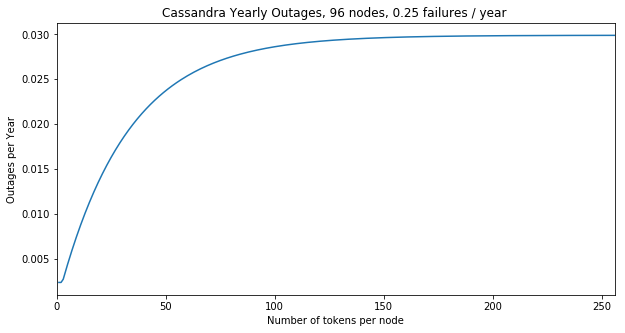

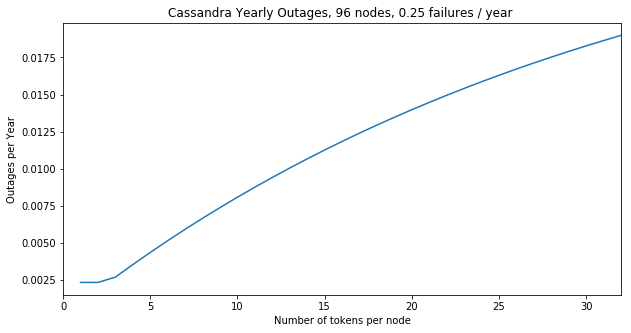

In [1]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  


def _comb(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

# Boils down to "If I pick nodes (rf - 1) * vnode times, how many
# distinct nodes will I have in expectation. Note that this is a slightly
# optimistic estimate because Cassandra won't place two replicas of the
# same token on the same machine or rack, but this is close enough for
# the model
# https://math.stackexchange.com/questions/72223/finding-expected-number-of-distinct-values-selected-from-a-set-of-integers
def num_neighbors(n, v, rf):
    k = v * (rf - 1)
    # As cassandra is rack aware, we assume #racks == #replicas
    # This is maybe a bad assumption for some datacenter deployments
    n = n - (n / rf)
    return sum((-1)**i * _comb(k, i + 1) * n**(-i) for i in range(0, k-1))

def p_outage_given_failure(recovery, num_neighbors, rate):
    x =  math.exp(-1 * recovery * num_neighbors * rate)
    return 1 - x

def exp_failures(num_nodes, rate, year):
    return num_nodes * rate * year

def recovery_c(size, bw_in, bw_out, neighbors):
    return int(size / (min(bw_in, neighbors * bw_out)))

num_nodes = 96
vnodes = 5
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
bw_out = 25

year = 60.0*60*24*365
arate = 0.25 / year


print("\nFailure Rate Variability")
neighbors = num_neighbors(num_nodes, vnodes, rf)
print("Neighbors for {0} vnodes: {1}".format(vnodes, neighbors))
recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)

for i in (0.125, 0.25, 0.5, 1, 2):
    rate = i / (year)
    failures = exp_failures(num_nodes, rate, year)
    probability = p_outage_given_failure(recovery, neighbors, rate)

    p = "{0:.3f} {1:.2f} {2:.6f} {3:.6f}".format(
        i, failures, probability, failures * probability
    )
    print(p)

print("\n\nVnode Variability under {0} machine failure rate".format(arate))
num_vnodes = range(1, 257)
outages = []
for vnode in num_vnodes:
    neighbors = num_neighbors(num_nodes, vnode, rf)
    recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)
    failures = exp_failures(num_nodes, arate, year)
    probability = p_outage_given_failure(recovery, neighbors, arate)
    p = "{0: <6} {1:.2f} {2: <6} {3:.6f}".format(
        vnode, neighbors, recovery, failures * probability
    )
    if vnode < 16 or vnode > 255:
        print(p)
    outages.append(failures * probability)
    
plt.figure(figsize=(10,5))
plt.title("Cassandra Yearly Outages, {0} nodes, {1:.2f} failures / year ".format(num_nodes, arate * year))
plt.ylabel("Outages per Year")
plt.xlabel("Number of tokens per node")
plt.xlim(0, 256)
plt.plot(num_vnodes, outages)

plt.figure(figsize=(10,5))
plt.title("Cassandra Yearly Outages, {0} nodes, {1:.2f} failures / year ".format(num_nodes, arate * year))
plt.ylabel("Outages per Year")
plt.xlabel("Number of tokens per node")
plt.xlim(0, 32)
plt.plot(num_vnodes[:32], outages[:32])